In [1]:
import sys
import os
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, isnull, sum as spark_sum
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['HADOOP_HOME'] = r'C:\hadoop'
os.environ['PATH'] = r'C:\hadoop\bin' + os.pathsep + os.environ['PATH']

project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ Setup complete")

✅ Setup complete


In [2]:
spark = SparkSession.builder \
    .appName("Quality Audit Pipeline") \
    .config("spark.sql.sources.commitProtocolClass", "org.apache.spark.sql.execution.datasources.SQLHadoopMapReduceCommitProtocol") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

print("\n🔥 Spark session active!")



🔥 Spark session active!


In [3]:
cleaned_path = os.path.join(project_root, 'data', 'cleaned', 'superstore_cleaned_spark.parquet')

print(f"Loading cleaned dataset: {cleaned_path}")
df = spark.read.parquet(cleaned_path)

print(f"\n📊 Dataset loaded")
print(f"Rows: {df.count():,}")
print(f"Columns: {len(df.columns)}")
print(f"\nColumns: {df.columns}")


Loading cleaned dataset: C:\Users\Administrator\Documents\Luxdev\used-cars-analysis-pipeline\data\cleaned\superstore_cleaned_spark.parquet

📊 Dataset loaded
Rows: 9,800
Columns: 18

Columns: ['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode', 'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State', 'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub_Category', 'Product_Name', 'Sales']


In [4]:
print("\n" + "="*70)
print("QUALITY CHECK 1: DATA COMPLETENESS")
print("="*70)

total_rows = df.count()
total_cells = total_rows * len(df.columns)

null_counts = df.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in df.columns]
).collect()[0].asDict()

missing_total = sum(null_counts.values())
completeness_score = (1 - missing_total / total_cells) * 100

print(f"\nCompleteness Score: {completeness_score:.2f}%")
print(f"Missing values: {missing_total:,}")
print(f"Total cells: {total_cells:,}")

if completeness_score == 100:
    print("✅ PASSED: No missing values")
else:
    print("⚠️  REVIEW: Some missing values remain")
    print("\nColumns with missing values:")
    for col_name, null_count in sorted(null_counts.items(), key=lambda x: x[1], reverse=True):
        if null_count > 0:
            print(f"  {col_name}: {null_count:,}")



QUALITY CHECK 1: DATA COMPLETENESS

Completeness Score: 99.99%
Missing values: 11
Total cells: 176,400
⚠️  REVIEW: Some missing values remain

Columns with missing values:
  Postal_Code: 11


In [5]:
print("\n" + "="*70)
print("QUALITY CHECK 2: DATA UNIQUENESS")
print("="*70)

duplicates = total_rows - df.dropDuplicates().count()
uniqueness_score = (1 - duplicates / total_rows) * 100

print(f"\nUniqueness Score: {uniqueness_score:.2f}%")
print(f"Duplicate rows: {duplicates:,}")

if duplicates == 0:
    print("✅ PASSED: No duplicates")
else:
    print("⚠️  REVIEW: Duplicates found")



QUALITY CHECK 2: DATA UNIQUENESS

Uniqueness Score: 100.00%
Duplicate rows: 0
✅ PASSED: No duplicates


In [6]:
print("\n" + "="*70)
print("QUALITY CHECK 3: BUSINESS RULE VALIDATION")
print("="*70)

violations = []

if 'Sales' in df.columns:
    negative_sales = df.filter(col('Sales') < 0).count()
    if negative_sales > 0:
        violations.append(f"Negative sales: {negative_sales} rows")
    print(f"\nSales validation: {negative_sales:,} negative values")

if 'Quantity' in df.columns:
    negative_qty = df.filter(col('Quantity') <= 0).count()
    if negative_qty > 0:
        violations.append(f"Invalid quantity: {negative_qty} rows")
    print(f"Quantity validation: {negative_qty:,} invalid values")

if 'Discount' in df.columns:
    invalid_discount = df.filter((col('Discount') < 0) | (col('Discount') > 1)).count()
    if invalid_discount > 0:
        violations.append(f"Invalid discount: {invalid_discount} rows")
    print(f"Discount validation: {invalid_discount:,} out-of-range values")

validity_score = (1 - len(violations) / 3) * 100 if len(violations) > 0 else 100

print(f"\nValidity Score: {validity_score:.2f}%")
if not violations:
    print("✅ PASSED: All business rules satisfied")
else:
    print("⚠️  VIOLATIONS:")
    for v in violations:
        print(f"  - {v}")



QUALITY CHECK 3: BUSINESS RULE VALIDATION

Sales validation: 0 negative values

Validity Score: 100.00%
✅ PASSED: All business rules satisfied


In [7]:
print("\n" + "="*70)
print("QUALITY CHECK 4: DATA CONSISTENCY")
print("="*70)

expected_numeric = ['Sales', 'Quantity', 'Profit', 'Discount']
type_issues = []

for col_name in expected_numeric:
    if col_name in df.columns:
        dtype = str(df.schema[col_name].dataType)
        if 'Integer' not in dtype and 'Double' not in dtype and 'Float' not in dtype:
            type_issues.append(f"{col_name} is {dtype}, expected numeric")

consistency_score = (1 - len(type_issues) / len(expected_numeric)) * 100

print(f"\nConsistency Score: {consistency_score:.2f}%")
if not type_issues:
    print("✅ PASSED: Data types consistent")
else:
    print("⚠️  ISSUES:")
    for issue in type_issues:
        print(f"  - {issue}")


QUALITY CHECK 4: DATA CONSISTENCY

Consistency Score: 100.00%
✅ PASSED: Data types consistent


In [8]:
print("\n" + "="*70)
print("OVERALL DATA QUALITY ASSESSMENT")
print("="*70)

overall_score = (completeness_score + uniqueness_score + validity_score + consistency_score) / 4

print(f"\n📊 Quality Dimensions:")
print(f"  • Completeness:  {completeness_score:.2f}%")
print(f"  • Uniqueness:    {uniqueness_score:.2f}%")
print(f"  • Validity:      {validity_score:.2f}%")
print(f"  • Consistency:   {consistency_score:.2f}%")
print(f"\n🎯 OVERALL QUALITY SCORE: {overall_score:.2f}/100")

if overall_score >= 95:
    print("\n✅ EXCELLENT: Data is production-ready")
elif overall_score >= 80:
    print("\n🟢 GOOD: Minor issues, mostly usable")
elif overall_score >= 60:
    print("\n🟡 FAIR: Significant issues to address")
else:
    print("\n🔴 POOR: Major quality problems")



OVERALL DATA QUALITY ASSESSMENT

📊 Quality Dimensions:
  • Completeness:  99.99%
  • Uniqueness:    100.00%
  • Validity:      100.00%
  • Consistency:   100.00%

🎯 OVERALL QUALITY SCORE: 100.00/100

✅ EXCELLENT: Data is production-ready


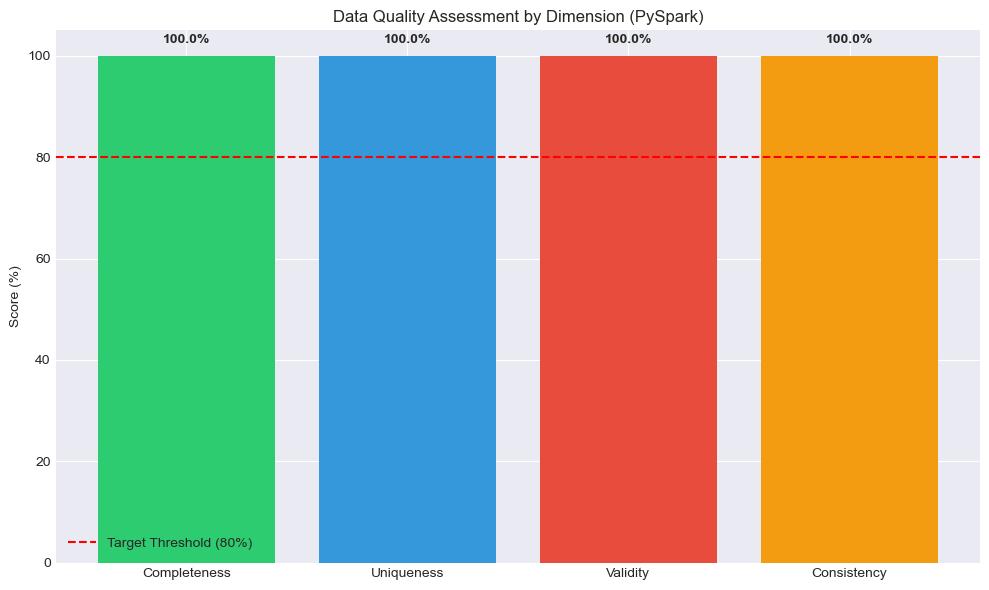


✅ Quality audit complete! Report saved to reports/figures/


In [9]:
scores = {
    'Completeness': completeness_score,
    'Uniqueness': uniqueness_score,
    'Validity': validity_score,
    'Consistency': consistency_score
}

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(scores.keys(), scores.values(), color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
ax.axhline(y=80, color='red', linestyle='--', label='Target Threshold (80%)')
ax.set_ylim(0, 105)
ax.set_ylabel('Score (%)')
ax.set_title('Data Quality Assessment by Dimension (PySpark)')
ax.legend()

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(project_root, 'reports', 'figures', 'quality_audit_pyspark.png'), dpi=300)
plt.show()

print("\n✅ Quality audit complete! Report saved to reports/figures/")

In [10]:
print("\n" + "="*70)
print("PANDAS vs PYSPARK COMPARISON")
print("="*70)

print("\n📊 Quality Score Comparison:")
print(f"  PySpark Overall Score: {overall_score:.2f}%")

spark.stop()
print("\n✅ Spark session stopped")



PANDAS vs PYSPARK COMPARISON

📊 Quality Score Comparison:
  PySpark Overall Score: 100.00%

✅ Spark session stopped
